Suha Lee <br>
1005155626 <br>
Last modified: 05-04-2024 <br>
INF2178 Technical Assignment 4 - Code

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install -q pingouin
import pingouin as pg
from statsmodels.stats.power import TTestIndPower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 1.8 MB/s eta 0:00:00


In [2]:
# Set filepath
filepath = '/content/drive/MyDrive/2023 2024 Semester 2/INF2178/A4/INF2178_A4_data.csv'

# Load dataset
mri_data = pd.read_csv(filepath, index_col=0)
mri_data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [3]:
# Display dataframe summary
mri_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 0 to 371
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  294 non-null    object 
 1   MRI ID      294 non-null    object 
 2   Group       294 non-null    object 
 3   Visit       294 non-null    int64  
 4   MR Delay    294 non-null    int64  
 5   M/F         294 non-null    object 
 6   Hand        294 non-null    object 
 7   Age         294 non-null    int64  
 8   EDUC        294 non-null    int64  
 9   SES         279 non-null    float64
 10  MMSE        293 non-null    float64
 11  CDR         294 non-null    float64
 12  eTIV        294 non-null    int64  
 13  nWBV        294 non-null    float64
 14  ASF         294 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 36.8+ KB


In [4]:
# Check which patients did not make two visits, to account for the missing six rows
visits = mri_data['Subject ID'].value_counts()
visits[visits != 2].index.tolist()

['OAS2_0017', 'OAS2_0018', 'OAS2_0036', 'OAS2_0007', 'OAS2_0133', 'OAS2_0089']

In [5]:
# Get number of patients in study
mri_data['Subject ID'].nunique()

150

In [6]:
# Get counts of observations by dementia status
mri_data['Group'].value_counts()

Group
Nondemented    142
Demented       126
Converted       26
Name: count, dtype: int64

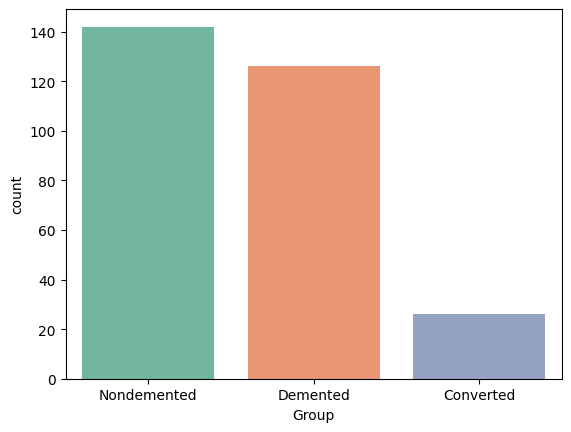

In [7]:
# Plot distribution of patients by dementia status
sns.countplot(x='Group', hue='Group', data=mri_data, palette='Set2', legend=False)
plt.show()

**Research Question 1:** How does dementia status affect changes in normalized whole brain volume (nWBV) over time?

In [8]:
# Select factors of interest
nWBV_data = mri_data[['Subject ID', 'Group', 'Visit', 'nWBV']]
nWBV_data.head()

,Subject ID,Group,Visit,nWBV
0,OAS2_0001,Nondemented,1,0.696
1,OAS2_0001,Nondemented,2,0.681
2,OAS2_0002,Demented,1,0.736
3,OAS2_0002,Demented,2,0.713
5,OAS2_0004,Nondemented,1,0.710


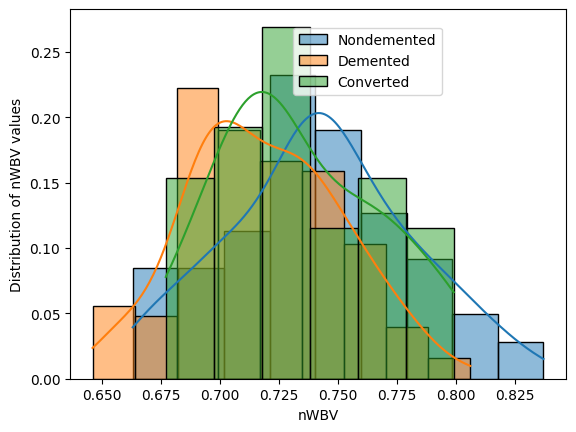

In [9]:
# Extract nWBV values by group
A = nWBV_data[nWBV_data['Group'] == 'Nondemented']['nWBV'].values
B = nWBV_data[nWBV_data['Group'] == 'Demented']['nWBV'].values
C = nWBV_data[nWBV_data['Group'] == 'Converted']['nWBV'].values

# Show the results of a linear regression within each group
ax1 = sns.histplot(A, label='Nondemented', kde=True, stat='probability')
ax2 = sns.histplot(B, label='Demented', kde=True,  stat='probability')
ax3 = sns.histplot(C, label='Converted', kde=True, stat='probability')

# Plot distributions of nWBV values by dementia status
plt.xlabel('nWBV')
plt.ylabel('Distribution of nWBV values')
plt.legend(bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)
plt.show()

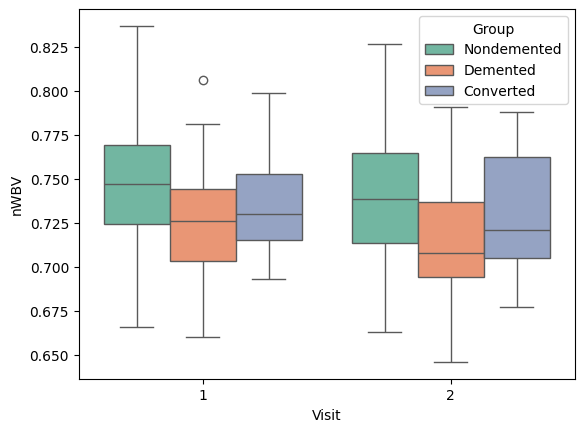

In [10]:
# Plot boxplots of nWBV by dementia status over time
sns.boxplot(x='Visit', y='nWBV', hue='Group', data=nWBV_data, palette='Set2')
plt.show()

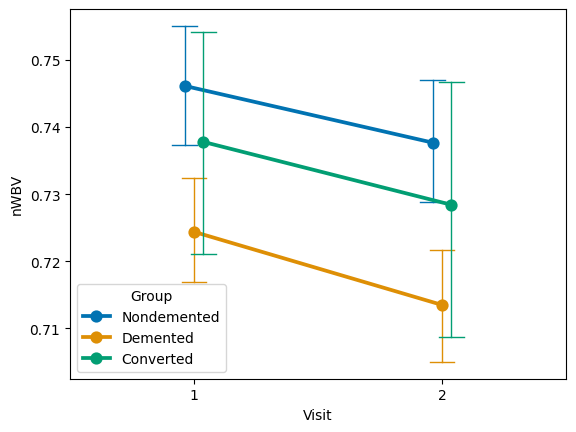

In [11]:
# Plot interaction of dementia status and time on nWBV
sns.pointplot(data=nWBV_data, x='Visit', y='nWBV', hue='Group', dodge=True,
	      capsize=.1, err_kws={'linewidth': 1}, palette='colorblind')
plt.show()

In [12]:
# Display descriptive statistics for nWBV by dementia status and time
nWBV_data.groupby(['Visit', 'Group'])['nWBV'].agg(['mean', 'std']).round(2)

mean   std
Visit Group                  
1     Converted    0.74  0.03
      Demented     0.72  0.03
      Nondemented  0.75  0.04
2     Converted    0.73  0.04
      Demented     0.71  0.03
      Nondemented  0.74  0.04

In [13]:
# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='nWBV', within='Visit', between='Group', subject='Subject ID', data=nWBV_data)
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
Group        0.034      2    141  0.017   6.712    0.002  0.087  nan
Visit        0.007      1    141  0.007  94.251    0.000  0.401    1.000
Interaction  0.000      2    141  0.000   1.534    0.219  0.021  nan



In [14]:
# Perform post-hoc tests
posthocs = pg.pairwise_tests(dv='nWBV', within='Visit', between='Group', subject='Subject ID', data=nWBV_data)
pg.print_table(posthocs)


POST HOC TESTS

Contrast       Visit    A          B            Paired    Parametric         T      dof  alternative      p-unc                 BF10    hedges
-------------  -------  ---------  -----------  --------  ------------  ------  -------  -------------  -------  -------------------  --------
Visit          -        1          2            True      True           9.672  143.000  two-sided        0.000  225800000000000.000     0.255
Group          -        Converted  Demented     False     True           1.401   14.676  two-sided        0.182                0.668     0.469
Group          -        Converted  Nondemented  False     True          -0.648   15.832  two-sided        0.527                0.361    -0.188
Group          -        Demented   Nondemented  False     True          -3.690  129.436  two-sided        0.000               75.094    -0.633
Visit * Group  1        Converted  Demented     False     True           1.444   14.626  two-sided        0.170              

In [15]:
# Perform Mauchly's test
pg.sphericity(data=nWBV_data, dv='nWBV', subject='Subject ID', within='Visit')[-1]

1.0

In [29]:
# Perform Shapiro-Wilk test
pg.normality(data=nWBV_data, dv='nWBV', group='Group')

,W,pval,normal
Group,,,
Nondemented,0.988882,0.317042,True
Demented,0.990468,0.540290,True
Converted,0.958236,0.358018,True


In [17]:
# Perform Levene's test
pg.homoscedasticity(data=nWBV_data, dv='nWBV', group='Visit')

,W,pval,equal_var
levene,0.504444,0.478121,True


**Research Question 2:** Is the progression of cognitive decline, as measured by Mini-Mental State Examination (MMSE) scores, influenced by dementia status?

In [18]:
# Select factors of interest
mmse_data = mri_data[['Subject ID', 'Group', 'Visit', 'MMSE']]
mmse_data.head()

,Subject ID,Group,Visit,MMSE
0,OAS2_0001,Nondemented,1,27.0
1,OAS2_0001,Nondemented,2,30.0
2,OAS2_0002,Demented,1,23.0
3,OAS2_0002,Demented,2,28.0
5,OAS2_0004,Nondemented,1,28.0


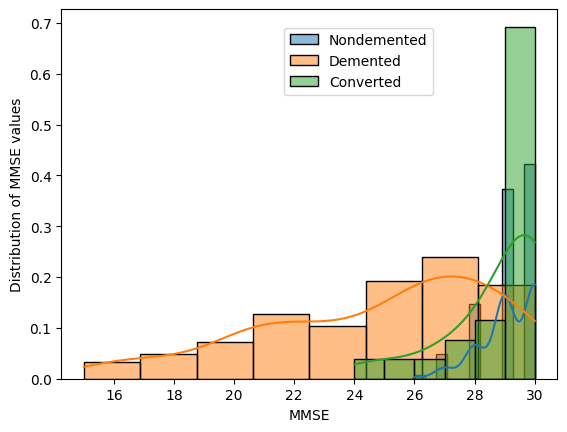

In [19]:
# Extract MMSE values by group
A = mmse_data[mmse_data['Group'] == 'Nondemented']['MMSE'].values
B = mmse_data[mmse_data['Group'] == 'Demented']['MMSE'].values
C = mmse_data[mmse_data['Group'] == 'Converted']['MMSE'].values


# Show the results of a linear regression within each group
ax1 = sns.histplot(A, label='Nondemented', kde=True, stat='probability')
ax2 = sns.histplot(B, label='Demented', kde=True,  stat='probability')
ax3 = sns.histplot(C, label='Converted', kde=True, stat='probability')

# Plot distributions of MMSE values by dementia status
plt.xlabel('MMSE')
plt.ylabel('Distribution of MMSE values')
plt.legend(bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)
plt.show()

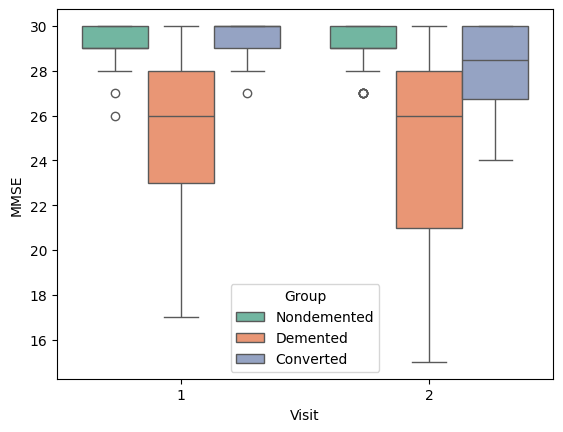

In [20]:
# Plot boxplots of MMSE by dementia status over time
sns.boxplot(x='Visit', y='MMSE', hue='Group', data=mmse_data, palette='Set2')
plt.show()

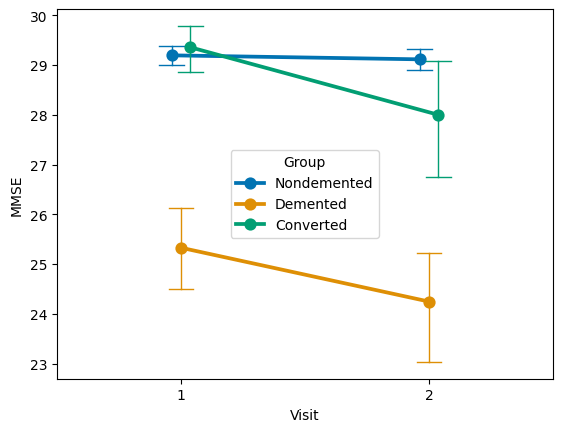

In [21]:
# Plot interaction of dementia status and time on MMSE
sns.pointplot(data=mmse_data, x='Visit', y='MMSE', hue='Group', dodge=True,
	      capsize=.1, err_kws={'linewidth': 1}, palette='colorblind')
plt.show()

In [22]:
# Display descriptive statistics for MMSE by dementia status and time
mmse_data.groupby(['Visit', 'Group'])['MMSE'].agg(['mean', 'std']).round(2)

mean   std
Visit Group                   
1     Converted    29.36  0.93
      Demented     25.33  3.32
      Nondemented  29.19  0.85
2     Converted    28.00  2.09
      Demented     24.25  4.40
      Nondemented  29.11  0.96

In [23]:
# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='MMSE', within='Visit', between='Group', subject='Subject ID', data=mmse_data)
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2       MS       F    p-unc    np2      eps
-----------  --------  -----  -----  -------  ------  -------  -----  -------
Group        1328.421      2    140  664.211  56.212    0.000  0.445  nan
Visit          22.378      1    140   22.378   8.859    0.003  0.060    1.000
Interaction    17.000      2    140    8.500   3.365    0.037  0.046  nan



In [24]:
# Perform post-hoc tests
posthocs = pg.pairwise_tests(dv='MMSE', within='Visit', between='Group', subject='Subject ID', data=mmse_data)
pg.print_table(posthocs)


POST HOC TESTS

Contrast       Visit    A          B            Paired    Parametric         T      dof  alternative      p-unc                BF10    hedges
-------------  -------  ---------  -----------  --------  ------------  ------  -------  -------------  -------  ------------------  --------
Visit          -        1          2            True      True           2.928  142.000  two-sided        0.004               5.530     0.162
Group          -        Converted  Demented     False     True           6.739   51.065  two-sided        0.000         2036000.000     1.167
Group          -        Converted  Nondemented  False     True          -1.303   12.315  two-sided        0.216               0.599    -0.584
Group          -        Demented   Nondemented  False     True          -9.449   64.318  two-sided        0.000  22070000000000.000    -1.754
Visit * Group  1        Converted  Demented     False     True           8.012   60.516  two-sided        0.000       318700000.000

In [25]:
# Perform Mauchly's test
pg.sphericity(data=mmse_data, dv='MMSE', subject='Subject ID', within='Visit')[-1]

1.0

In [30]:
# Perform Shapiro-Wilk test
pg.normality(data=mmse_data, dv='MMSE', group='Group')

,W,pval,normal
Group,,,
Nondemented,0.809528,2.635762e-12,False
Demented,0.929083,5.677786e-06,False
Converted,0.770938,5.867723e-05,False


Power Analysis

In [27]:
# Parameters for power test
power = 0.91
alpha = 0.05
effect_size = 0.7

# Create an instance of TTestIndPower
obj = TTestIndPower()

# Calculate sample size
n = obj.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

print('Sample size/Number needed in each group: {:.3f}'.format(n))

Sample size/Number needed in each group: 45.451


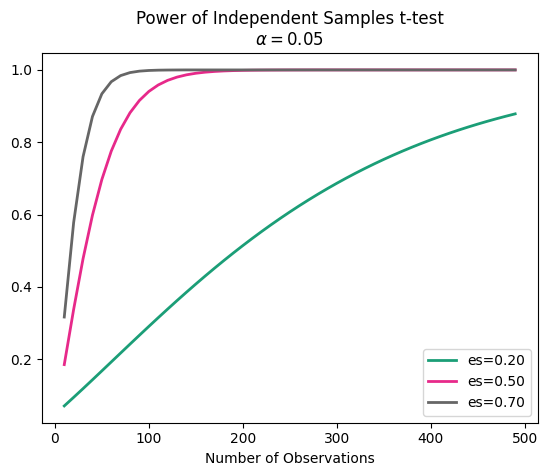

In [28]:
# Creat statistical power analysis plot
effect_sizes = np.array([0.2, 0.5, 0.7])
sample_sizes = np.array(range(10, 500, 10))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig = obj.plot_power(
    dep_var='nobs', nobs=sample_sizes,
    effect_size=effect_sizes, alpha=0.05, ax=ax,
    title='Power of Independent Samples t-test\n$\\alpha = 0.05$')
plt.show()